# Selección de parámetros

In [1]:
from copy import deepcopy
import os
import re
from typing import Any

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from config import DATA_PATH, MODELS_PATH, VISUALIZATIONS_PATH

## Carga de datos y vectorizadores

In [2]:
data = pd.read_csv(os.path.join(DATA_PATH, "session_speech.csv"))

INDEX = os.path.join(MODELS_PATH, "index")
X_train_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_train_index.csv"), header=None, index_col=0)
    .index
)
X_test_index = (
    pd
    .read_csv(os.path.join(INDEX, f"X_test_index.csv"), header=None, index_col=0)
    .index
)

le = joblib.load(os.path.join(MODELS_PATH, "labelencoder.pkl"))

VECTORIZERS = os.path.join(MODELS_PATH, "vectorizers")
pos_vectorizer = joblib.load(os.path.join(VECTORIZERS, "pos_vectorizer.pkl"))
proportions_vectorizer = joblib.load(os.path.join(VECTORIZERS, "proportions_vectorizer.pkl"))
logodds_vectorizer = joblib.load(os.path.join(VECTORIZERS, "logodds_vectorizer.pkl"))

In [3]:
data = (
    data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
    .reset_index(drop=True)
)

## Vectorización de datos

In [4]:
TRAINSET_FOLDER = os.path.join(MODELS_PATH, "trainsets")
os.makedirs(TRAINSET_FOLDER, exist_ok=True)

In [5]:
def build_features(
    df: pd.DataFrame, converters: dict[str, CountVectorizer], test: bool = True
):
    features, features_names = list(), list()
    for column, vectorizer in converters.items():
        if test:
            X = vectorizer.transform(df[column])
        else:
            X = vectorizer.fit_transform(df[column])
        print(f"{X.shape[1]} features added")
        features.append(X)
        features_names.extend(list(vectorizer.get_feature_names_out()))
    features_array = np.concatenate(list(map(lambda x: x.toarray(), features)), axis=1)
    features_df = pd.DataFrame(features_array, columns=features_names)
    return features_df

In [6]:
out_file = os.path.join(TRAINSET_FOLDER, "X_train_proportions.csv")

X_train_proportions = build_features(
    data.iloc[X_train_index],
    converters={"speech_lemmas": proportions_vectorizer, "speech_pos": pos_vectorizer}
)
X_train_proportions.to_csv(out_file, index=False)

505 features added
13 features added


In [7]:
out_file = os.path.join(TRAINSET_FOLDER, "X_train_logodds.csv")

X_train_logodds = build_features(
    data.iloc[X_train_index],
    converters={"speech_lemmas": logodds_vectorizer, "speech_pos": pos_vectorizer}
)
X_train_logodds.to_csv(out_file, index=False)

480 features added
13 features added


In [8]:
y_train = le.transform(data.loc[X_train_index, "vote"])

## Búsqueda exhaustiva

In [9]:
# about generated folds and random state
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

def fit_grid_search(
    clf: BaseEstimator, clf_parameters: dict[str, Any],
    X:pd.DataFrame, y:pd.Series,
    out_file: str = None
):
    gs = GridSearchCV(
        clf,
        clf_parameters,
        scoring='f1',
        cv=5,
        return_train_score=True,
        n_jobs=-1
    )
    gs.fit(X, y)
    if out_file:
        FOLDER = os.path.join(MODELS_PATH, "gridsearch")
        os.makedirs(FOLDER, exist_ok=True)
        FILE = os.path.join(FOLDER, out_file)
        joblib.dump(gs, FILE, compress=True)
    return gs

In [10]:
def build_results(cv_results: dict[str, np.ndarray]) -> pd.DataFrame:
    df_cv_results = pd.DataFrame(cv_results)
    param_cols = df_cv_results.filter(regex="param_").columns.tolist()
    df_cv_results.drop(columns=param_cols, inplace=True)
    df_cv_results["params"] = (
        df_cv_results
        .params
        .apply(lambda x: "-".join([f"{k}={v}" for k, v in x.items()]))
    )
    df_cv_results.set_index("params", inplace=True)
    df_cv_results.sort_values(by="rank_test_score", inplace=True)
    df_cv_results = df_cv_results[df_cv_results.columns.sort_values().tolist()]
    return df_cv_results

In [11]:
def build_results2plot(results: pd.DataFrame) -> pd.DataFrame:
    split_cols = results.filter(regex=r"(split\d+\_test)").columns.to_list()
    return (
        pd.concat([
            results.nlargest(3, "mean_test_score"),
            results.nsmallest(3, "std_test_score")
        ])
        .drop_duplicates(keep="first")
        .reset_index()
        .melt(
            id_vars = ["params"],
            value_vars = split_cols,
            var_name = "measure"
        )
        .merge(
            results[["mean_test_score", "std_test_score"]],
            left_on = "params", right_index = True
        )
        .reset_index(drop=True)
    )

In [12]:
def plot_results(
    results: pd.DataFrame,
    clf: str,
    file_name: str = None,
    ncol: int = None,
    bbox_y: int = None
    ) -> None:
    results2plot = build_results2plot(results)
    fig, axs = plt.subplots(1, 2, figsize=(9,3))
    for params, df in results2plot.groupby("params"):
        _df = df[["params", "mean_test_score", "std_test_score"]].drop_duplicates(keep="first")
        axs[0].errorbar(
            x=_df.mean_test_score,
            xerr=_df.std_test_score,
            y=_df.params,
            fmt="o",
            label=params
        )
        axs[1].errorbar(
            x=df.measure,
            y=df.value,
            label=params
        )
    axs[0].set_yticks([])
    axs[0].set_xlabel("")
    axs[0].set_title("Promedio y desvío")
    axs[1].set_xticklabels([
        "split {n}".format(n=re.search(r'\d+', label.get_text()).group())
        for label in axs[1].get_xticklabels()
    ])
    axs[1].set_xlabel("")
    axs[1].set_title("Por split")
    title = fig.suptitle(f"{clf}:\nF1-score en test en validación cruzada", y=1.13)
    if ncol is None:
        n_models = results2plot.params.nunique()
        ncol = min(n_models, 4)
    bbox_y = bbox_y if bbox_y else -0.3
    lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, bbox_y), ncol=ncol)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[lgd,title], bbox_inches='tight'
        )

### Naive Bayer Multinomial

In [13]:
nb_gridsearch = dict()

for df, name in zip([X_train_proportions, X_train_logodds], ["proporciones", "log-odds"]):
    gs = fit_grid_search(
        clf=MultinomialNB(),
        clf_parameters={"alpha": [0.01, 0.1, 1.0]},
        X=df,
        y=y_train,
        out_file=f"nb_{name}.pkl"
    )
    nb_gridsearch[name] = {"trainset": df, "grid_search": gs}

In [14]:
for key in nb_gridsearch.keys():
    print(f"--- {key.upper()} ---")
    print(nb_gridsearch[key]["grid_search"])

--- PROPORCIONES ---
GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0]}, return_train_score=True,
             scoring='f1')
--- LOG-ODDS ---
GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0]}, return_train_score=True,
             scoring='f1')


In [15]:
nb_gridsearch_results = dict()

for key, value in nb_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    nb_gridsearch_results[key] = results
    print(f"--- {key.upper()} ---")
    print(results.T.head())

--- PROPORCIONES ---
params            alpha=0.01  alpha=1.0  alpha=0.1
mean_fit_time       0.050619   0.052048   0.054899
mean_score_time     0.007377   0.005862   0.008025
mean_test_score     0.691389   0.691060   0.672669
mean_train_score    0.746886   0.748336   0.746886
rank_test_score     1.000000   2.000000   3.000000
--- LOG-ODDS ---
params            alpha=0.1  alpha=1.0  alpha=0.01
mean_fit_time      0.010793   0.010469    0.009809
mean_score_time    0.011591   0.008663    0.008711
mean_test_score    0.626103   0.604519    0.593642
mean_train_score   0.668947   0.669140    0.671339
rank_test_score    1.000000   2.000000    3.000000


/tmp/ipykernel_105088/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([
/tmp/ipykernel_105088/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


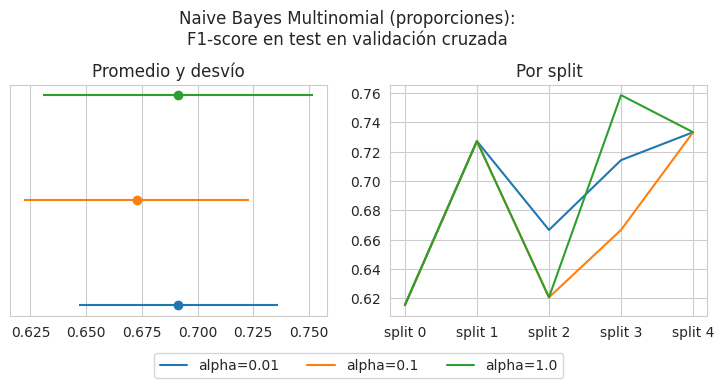

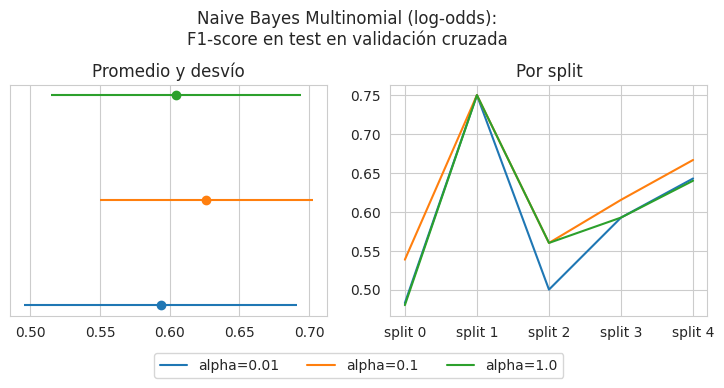

In [16]:
for key, value in nb_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    plot_results(
        results,
        f"Naive Bayes Multinomial ({key})",
        file_name=f"nb_f1score_split_comparison_{key}"
    )

### Regresión Logística

In [17]:
lr_gridsearch = dict()

for df, name in zip([X_train_proportions, X_train_logodds], ["proporciones", "log-odds"]):
    gs = fit_grid_search(
        clf=LogisticRegression(multi_class="ovr", solver="liblinear", random_state=6300),
        clf_parameters={"penalty": ["l1", "l2"], "C": [0.1, 0.5, 1]},
        X=df,
        y=y_train,
        out_file=f"lr_{name}.pkl"
    )
    lr_gridsearch[name] = {"trainset": df, "grid_search": gs}

In [18]:
for key in lr_gridsearch.keys():
    print(f"--- {key.upper()} ---")
    print(lr_gridsearch[key]["grid_search"])

--- PROPORCIONES ---
GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=6300,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')
--- LOG-ODDS ---
GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=6300,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')


In [19]:
lr_gridsearch_results = dict()

for key, value in lr_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    lr_gridsearch_results[key] = results
    print(f"--- {key.upper()} ---")
    print(results.T.head())

--- PROPORCIONES ---
params            C=0.1-penalty=l2  C=0.5-penalty=l2  C=1-penalty=l2  \
mean_fit_time             0.007589          0.007022        0.008160   
mean_score_time           0.006989          0.007631        0.006053   
mean_test_score           0.683181          0.681639        0.673618   
mean_train_score          0.817717          0.859061        0.873400   
rank_test_score           1.000000          2.000000        3.000000   

params            C=1-penalty=l1  C=0.5-penalty=l1  C=0.1-penalty=l1  
mean_fit_time           0.007077          0.007059          0.006723  
mean_score_time         0.006394          0.006184          0.007621  
mean_test_score         0.612484          0.590736          0.454496  
mean_train_score        0.811028          0.779690          0.518188  
rank_test_score         4.000000          5.000000          6.000000  
--- LOG-ODDS ---
params            C=0.1-penalty=l2  C=1-penalty=l2  C=1-penalty=l1  \
mean_fit_time             0.01149

/tmp/ipykernel_105088/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([
/tmp/ipykernel_105088/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


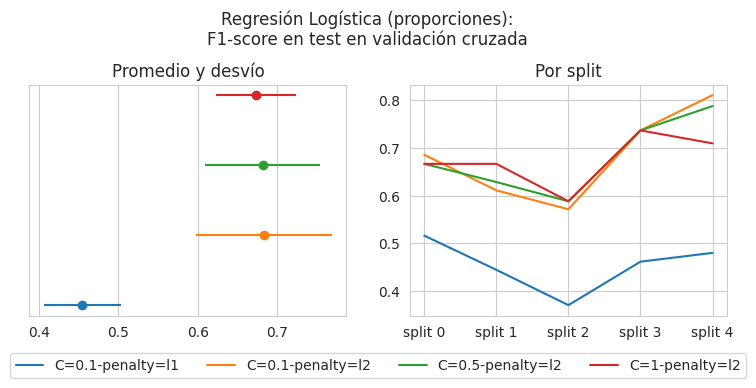

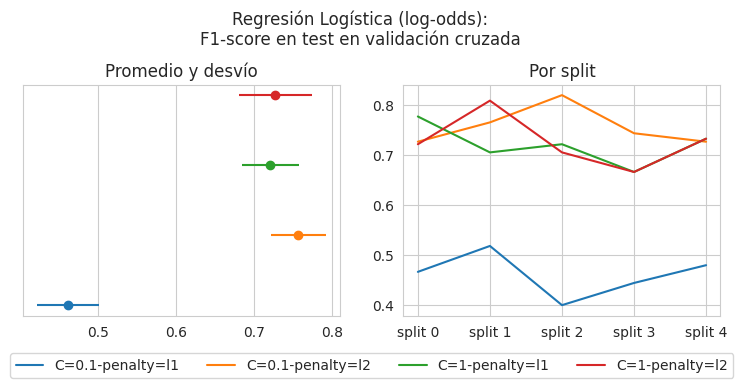

In [20]:
for key, value in lr_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    plot_results(
        results,
        f"Regresión Logística ({key})",
        file_name=f"lr_f1score_split_comparison_{key}"
    )

### Máquinas de Soporte Vectorial

In [21]:
svm_gridsearch = dict()

for df, name in zip(
    [X_train_proportions, X_train_logodds], ["proporciones", "log-odds"]
    ):
    gs = fit_grid_search(
        clf=SVC(random_state=6300),
        clf_parameters={
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "C": [0.1, 0.5, 1],
            "decision_function_shape": ["ovo", "ovr"]
        },
        X=df,
        y=y_train,
        out_file=f"svm_{name}.pkl"
    )
    svm_gridsearch[name] = {"trainset": df, "grid_search": gs}

In [22]:
for key in svm_gridsearch.keys():
    print(f"--- {key.upper()} ---")
    print(lr_gridsearch[key]["grid_search"])

--- PROPORCIONES ---
GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=6300,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')
--- LOG-ODDS ---
GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=6300,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1')


In [23]:
svm_gridsearch_results = dict()

for key, value in svm_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    svm_gridsearch_results[key] = results
    print(f"--- {key.upper()} ---")
    print(results.T.head())

--- PROPORCIONES ---
params            C=0.1-decision_function_shape=ovo-kernel=rbf  \
mean_fit_time                                         0.011714   
mean_score_time                                       0.009810   
mean_test_score                                       0.717667   
mean_train_score                                      0.717737   
rank_test_score                                       1.000000   

params            C=0.1-decision_function_shape=ovo-kernel=sigmoid  \
mean_fit_time                                             0.009106   
mean_score_time                                           0.007207   
mean_test_score                                           0.717667   
mean_train_score                                          0.717737   
rank_test_score                                           1.000000   

params            C=0.1-decision_function_shape=ovr-kernel=rbf  \
mean_fit_time                                         0.008741   
mean_score_time              

/tmp/ipykernel_105088/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([
/tmp/ipykernel_105088/1728367519.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([


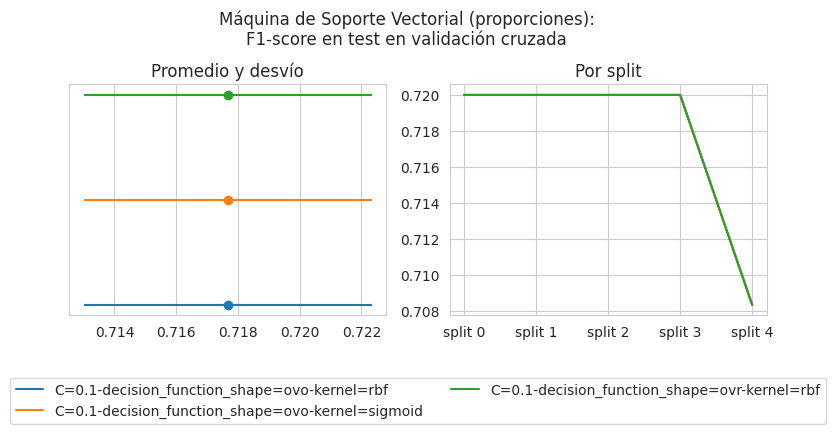

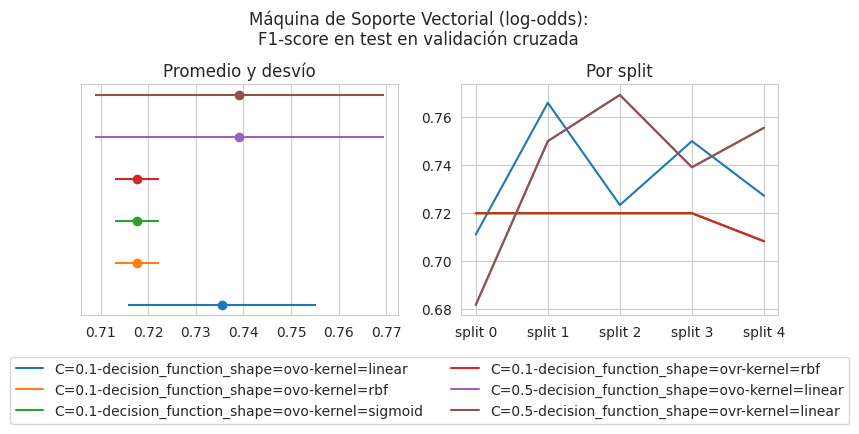

In [24]:
for key, value in svm_gridsearch.items():
    results = build_results(value["grid_search"].cv_results_)
    f = plot_results(
        results,
        f"Máquina de Soporte Vectorial ({key})",
        ncol=2,
        bbox_y=-.5,
        file_name=f"svm_f1score_split_comparison_{key}"
    )

## Selección de mejores estimadores

In [25]:
def print_best_estimator_info(gs_estimators: GridSearchCV) -> None:
    best_params = "\n\t- ".join(
        [f"{k}: {v}" for k, v in gs_estimators.best_params_.items()]
    )
    print(f"""
    ** Mejor conjunto de parámetros:\n\t- {best_params}
    ** Mejor score promedio en validación cruzada: {gs_estimators.best_score_}
    """)

### Multinomial Naive Bayes

In [26]:
for key, value in nb_gridsearch.items():
    print(f"--- {key.upper()} ---")
    print_best_estimator_info(value["grid_search"])

--- PROPORCIONES ---

    ** Mejor conjunto de parámetros:
	- alpha: 0.01
    ** Mejor score promedio en validación cruzada: 0.6913886113886114
    
--- LOG-ODDS ---

    ** Mejor conjunto de parámetros:
	- alpha: 0.1
    ** Mejor score promedio en validación cruzada: 0.6261025641025642
    


### Logistic Regression

In [27]:
for key, value in lr_gridsearch.items():
    print(f"--- {key.upper()} ---")
    print_best_estimator_info(value["grid_search"])

--- PROPORCIONES ---

    ** Mejor conjunto de parámetros:
	- C: 0.1
	- penalty: l2
    ** Mejor score promedio en validación cruzada: 0.6831813768655873
    
--- LOG-ODDS ---

    ** Mejor conjunto de parámetros:
	- C: 0.1
	- penalty: l2
    ** Mejor score promedio en validación cruzada: 0.7570403536756827
    


### Máquinas de Soporte Vectorial

In [28]:
for key, value in svm_gridsearch.items():
    print(f"--- {key.upper()} ---")
    print_best_estimator_info(value["grid_search"])

--- PROPORCIONES ---

    ** Mejor conjunto de parámetros:
	- C: 0.1
	- decision_function_shape: ovo
	- kernel: rbf
    ** Mejor score promedio en validación cruzada: 0.7176666666666666
    
--- LOG-ODDS ---

    ** Mejor conjunto de parámetros:
	- C: 0.5
	- decision_function_shape: ovo
	- kernel: linear
    ** Mejor score promedio en validación cruzada: 0.7391469882774231
    


## Importancia de rasgos

In [29]:
FOLDER = os.path.join(MODELS_PATH, "refit")
os.makedirs(FOLDER, exist_ok=True)

### Naive Bayes Multinomial

In [30]:
def plot_nb_weights(df: pd.DataFrame, title:str, file_name:str = None):
    fig, axs = plt.subplots(1,2, figsize=(12,3), sharey=True)
    sns.histplot(
        data = df.melt(id_vars=["word"], var_name="weight"),
        x="value",
        hue="weight",
        bins=30,
        ax=axs[0]
    )
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Observaciones")
    axs[0].set_title("Pesos por categoría")
    axs[0].get_legend().set_title("Pesos")
    sns.histplot(
        data = df.assign(diff=lambda x: x.pos-x.neg),
        x="diff",
        bins=30,
        ax=axs[1]
    )
    axs[1].set_title("Diferencia de pesos: $pos-neg$")
    title = fig.suptitle(title,  y=1.05)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title], bbox_inches='tight'
        )

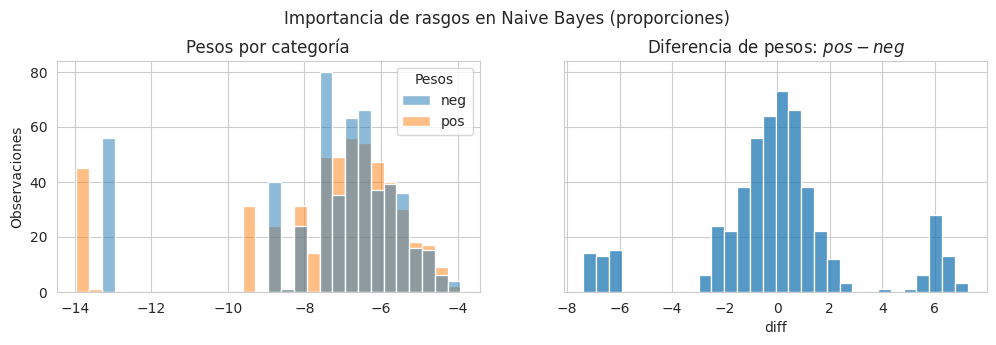

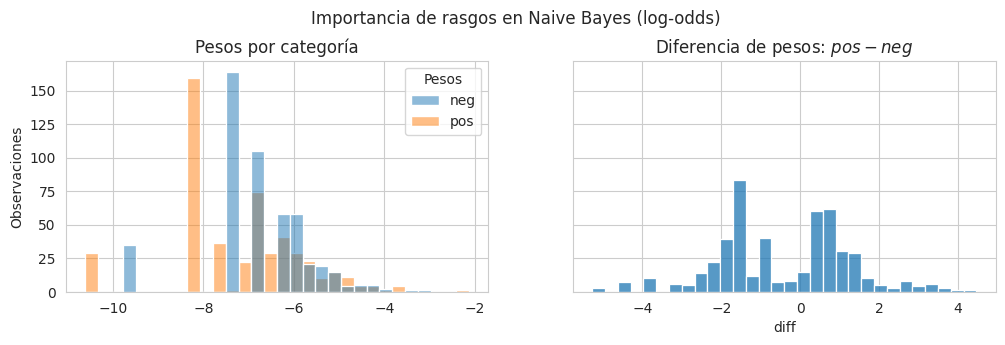

In [31]:
for key, value in nb_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    value["refit"] = estimator.fit(x_train, y_train)
    best_nb_weights = pd.DataFrame(
        {
            "word": x_train.columns.to_list(),
            "neg": estimator.feature_log_prob_[0],
            "pos": estimator.feature_log_prob_[1]
        }
    )
    value["refit_weights"] = best_nb_weights
    FILE = os.path.join(FOLDER, f"nb_{key}.pkl")
    joblib.dump(estimator, FILE, compress=True)
    plot_nb_weights(
        best_nb_weights,
        title=f"Importancia de rasgos en Naive Bayes ({key})",
        file_name=f"nb_best_feature_importance_{key}"
    )

### Regresión Logística

In [32]:
def plot_lr_weights(df: pd.DataFrame, title:str, file_name:str=None):
    df_copy = deepcopy(df)
    df_copy.loc[df_copy.coef >= 0, "weight"] = "pos"
    df_copy.loc[df_copy.coef < 0, "weight"] = "neg"
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(
        data = df_copy,
        x="coef",
        hue="weight",
        bins=30,
        ax=ax
    )
    ax.set_xlabel("")
    ax.set_ylabel("Observaciones")
    ax.get_legend().set_title("Pesos")
    fig.suptitle(title)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title]
        )

def plot_lr_weights_barplot(
        df: pd.DataFrame,
        title:str,
        n: int = 25,
        file_name:str=None
    ):
    fig, axs = plt.subplots(1, 2, figsize=(9,6))
    sns.barplot(
        df[df.coef<0].nsmallest(n, columns=["coef"], keep="all"),
        x = "coef", y = "word",
        ax=axs[0],
        palette="tab10",
        alpha=.6
    )
    axs[0].set_title("Coeficientes negativos")
    axs[0].set_ylabel("")
    axs[0].set_xlabel("Magnitudd")
    sns.barplot(
        df[df.coef>=0].nlargest(n, columns=["coef"], keep="all"),
        x = "coef", y = "word",
        ax=axs[1],
        palette="tab10",
        alpha=.6
    )
    axs[1].set_title("Coeficientes positivos")
    axs[1].yaxis.tick_right()
    axs[1].set_ylabel("")
    axs[1].set_xlabel("Magnitudd")
    fig.suptitle(title, fontsize=14)
    if file_name:
        FOLDER = os.path.join(VISUALIZATIONS_PATH, "models")
        os.makedirs(FOLDER, exist_ok=True)
        out_file = os.path.join(FOLDER, f"{file_name}.png")
        fig.savefig(
            out_file, bbox_extra_artists=[title]
        )

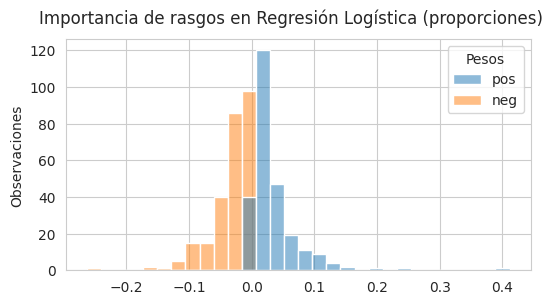

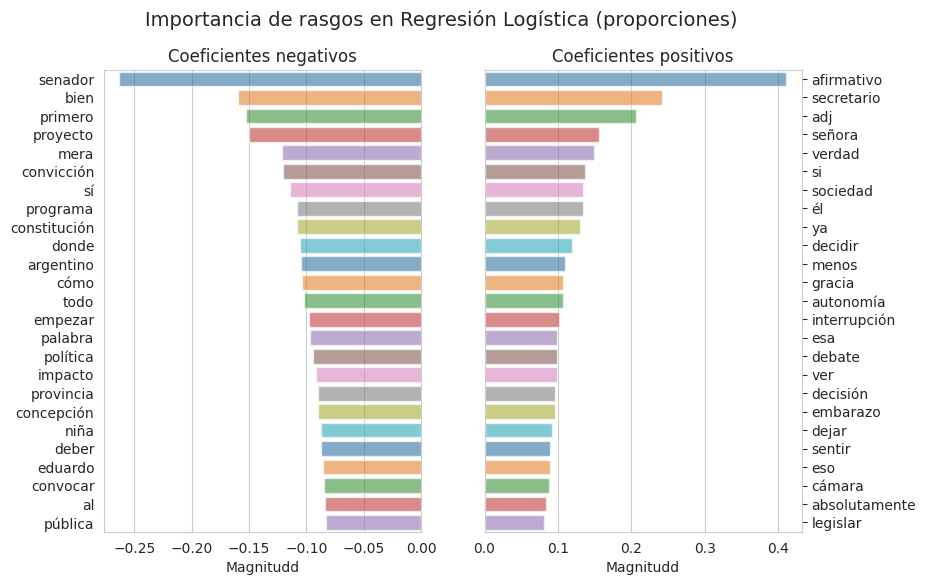

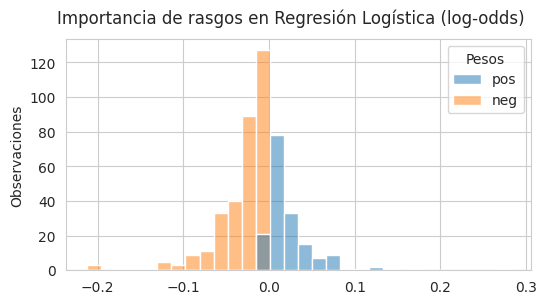

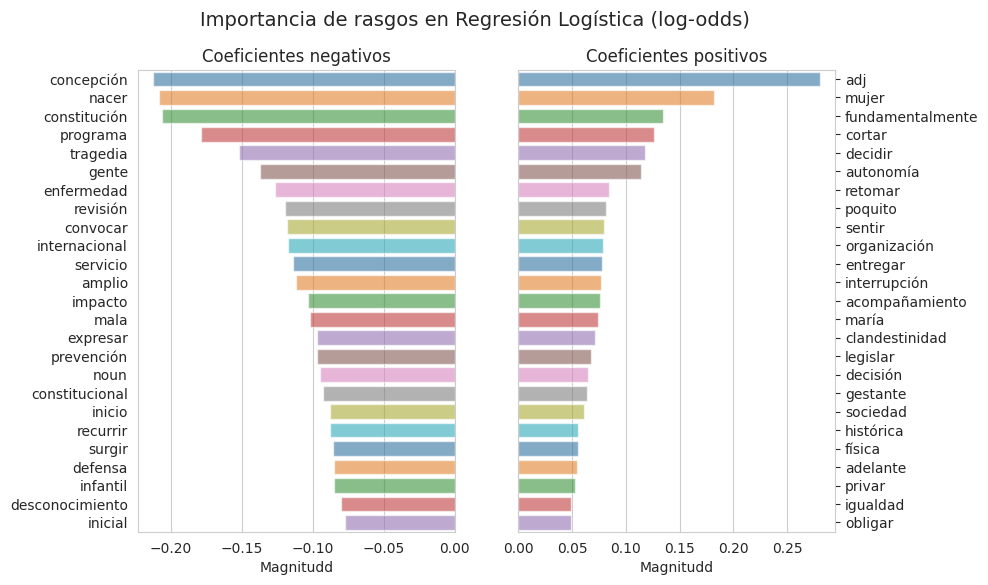

In [33]:
for key, value in lr_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    value["refit"] = estimator.fit(x_train, y_train)
    best_lr_weights = pd.DataFrame(
        {
            "word": x_train.columns.to_list(),
            "coef": estimator.coef_[0]
        }
    )
    value["refit_weights"] = best_lr_weights
    FILE = os.path.join(FOLDER, f"lr_{key}.pkl")
    joblib.dump(estimator, FILE, compress=True)
    plot_lr_weights(
        best_lr_weights,
        title=f"Importancia de rasgos en Regresión Logística ({key})",
        file_name=f"lr_best_feature_importance_{key}"
    )
    plot_lr_weights_barplot(
        best_lr_weights,
        title=f"Importancia de rasgos en Regresión Logística ({key})",
        file_name=f"lr_best_feature_importance_barplot_{key}"
    )

### Máquinas de Soporte Vectorial

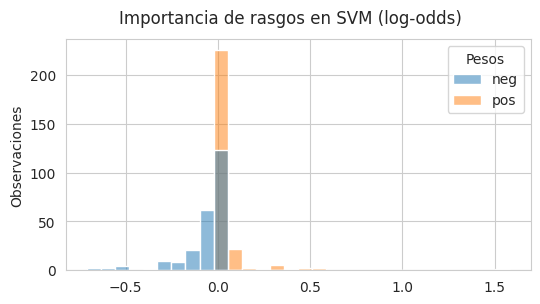

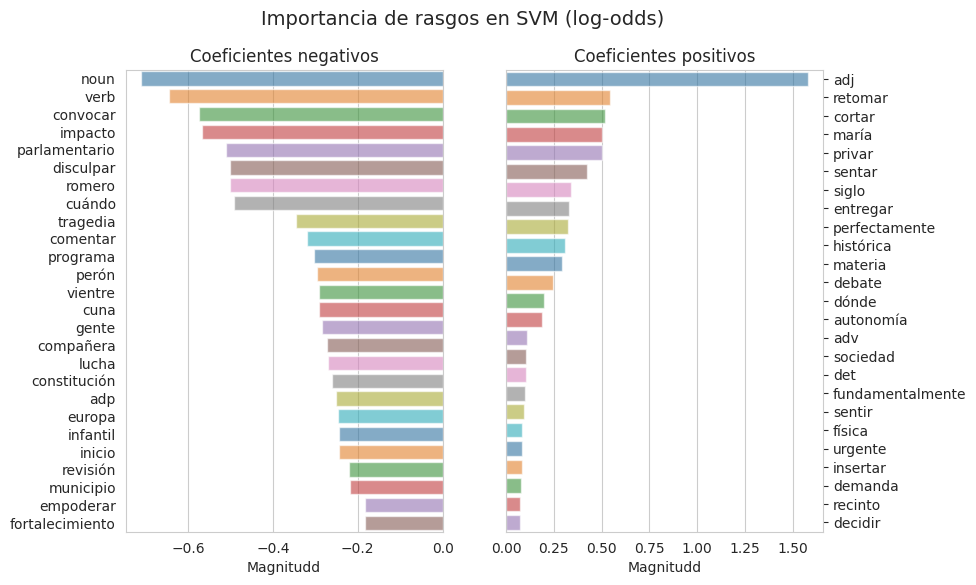

In [35]:
for key, value in svm_gridsearch.items():
    estimator, x_train = value["grid_search"].best_estimator_, value["trainset"]
    value["refit"] = estimator.fit(x_train, y_train)
    FILE = os.path.join(FOLDER, f"svm_{key}.pkl")
    joblib.dump(estimator, FILE, compress=True)
    if estimator.kernel == "linear":
        best_svm_weights = pd.DataFrame(
            {
                "word": x_train.columns.to_list(),
                "coef": estimator.coef_[0],
            }
        )
        value["refit_weights"] = best_nb_weights
        plot_lr_weights(
            best_svm_weights,
            title=f"Importancia de rasgos en SVM ({key})",
            file_name=f"svm_best_feature_importance_{key}"
        )
        plot_lr_weights_barplot(
            best_svm_weights,
            title=f"Importancia de rasgos en SVM ({key})",
            file_name=f"svm_best_feature_importance_barplot{key}"
        )